### Choose from configuration files

In [1]:
using Reactive, Interact

filenames = ["2dLink", "2dFall", "2dSwim", "2dThrow", "3dHinge", 
             "3dPrismatic", "3dCylindrical", "2dFallingCircle"]
# 2d body is always constructed in z-x plane
file = dropdown(filenames)

Interact.Options{:Dropdown,Any}(1: "input" = 2dLink Any , "", "2dLink", "2dLink", 0, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("2dLink"=>"2dLink","2dFall"=>"2dFall","2dSwim"=>"2dSwim","2dThrow"=>"2dThrow","3dHinge"=>"3dHinge","3dPrismatic"=>"3dPrismatic","3dCylindrical"=>"3dCylindrical","2dFallingCircle"=>"2dFallingCircle"), Dict{Any,Any}(Pair{Any,Any}("2dLink", "2dLink"),Pair{Any,Any}("2dFall", "2dFall"),Pair{Any,Any}("2dThrow", "2dThrow"),Pair{Any,Any}("3dCylindrical", "3dCylindrical"),Pair{Any,Any}("3dHinge", "3dHinge"),Pair{Any,Any}("2dFallingCircle", "2dFallingCircle"),Pair{Any,Any}("2dSwim", "2dSwim"),Pair{Any,Any}("3dPrismatic", "3dPrismatic"))), Any[], Any[], true, "horizontal")

### Include Dyn3d and config files

In [2]:
include(Pkg.dir("Dyn3d")*"/src/Dyn3d.jl")
using Dyn3d
using Plots
pyplot()

Plots.PyPlotBackend()

In [3]:
map(x -> include("../src/config_files/"*x*".jl"), signal(file))

Config info set up.


nothing

### Build joint-body chain

In [4]:
bodys, joints, system = BuildChain(config_bodys, config_joints, 
                                   config_system)
bd = BodyDyn(bodys, joints, system)

### Initialize system state

In [5]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs))

nothing

This is a 6 body-joint system.
System is un-mounted from space


### Set up HERKBody object

In [6]:
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!))

Order-5 HERK integrator.


### Time Marching

In [7]:
# advance in time
idx = 0
@time begin
while soln.t < tf
    # advance one step
#     soln, bd.bs, bd.js, bd.sys = herk(soln, bd)
    soln, bd = herk(soln, bd, _isfixedstep=true)
        
    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))
        
    # print progress
    idx += 1
    if mod(idx,500) == 1 
        @printf("itr = %d, t = %.3f, dt = %e\n", idx, soln.t, soln.dt)
#         println("center of mass at", MassCenter(bodys, system))
    end
end
@printf("itr = %d, t = %.3f, dt = %e\n", idx, soln.t, soln.dt)
end

itr = 1, t = 0.001, dt = 1.000000e-03
itr = 501, t = 0.501, dt = 1.000000e-03
itr = 1001, t = 1.001, dt = 1.000000e-03
itr = 1501, t = 1.501, dt = 1.000000e-03
itr = 2001, t = 2.001, dt = 1.000000e-03
itr = 2501, t = 2.501, dt = 1.000000e-03
itr = 3001, t = 3.001, dt = 1.000000e-03
itr = 3501, t = 3.501, dt = 1.000000e-03
itr = 4001, t = 4.001, dt = 1.000000e-03
itr = 4001, t = 4.001, dt = 1.000000e-03
 16.013823 seconds (30.29 M allocations: 5.975 GiB, 6.73% gc time)


### Save verts data on regulated time grid for movie in Matlab

In [8]:
bodys, joints, system = bd.bs, bd.js, bd.sys

using MAT
using Interpolations

# create regular time grid and acquire solutions on it
qJ_regs = Float64[]
t_reg = linspace(0,solns[end].t,length(solns))
for i = 1:system.ndof
    t_temp = ([solns[k].t for k = 1:length(solns)],)
    qJ_temp = [solns[k].qJ[i] for k = 1:length(solns)]   
    qJ_reg = interpolate(t_temp, qJ_temp, Gridded(Linear()))[t_reg]
    append!(qJ_regs, qJ_reg)
end
qJ_regs = reshape(qJ_regs,(length(solns), system.ndof))

# get verts info based on this regular grid solution
vs_reg = []
bodys_reg = deepcopy(bodys)
joints_reg = deepcopy(joints)
system_reg = deepcopy(system)
for i = 1:length(solns)
    bodys_reg, joints_reg, system_reg = UpdatePosition!(bodys_reg, joints_reg, system_reg, solns[i].qJ)
    push!(vs_reg, VertsHistory(system.nbody, bodys_reg))
end

# write to .mat file for animation
# vs_reg follow the form [ntime][nbody, nverts, xyz]
matwrite("../matlab_plot/verts_i.mat", Dict(
    "ndim" => system.ndim,
    "nbody" => system.nbody,
    "nverts" => bodys[1].nverts,
    "t" => collect(t_reg),
    "verts" => vs_reg
))

### Interactive plot

Interact.Options{:SelectionSlider,Any}(5: "input-2" = 20 Any , "i", 20, "20", 20, Interact.OptionDict(DataStructures.OrderedDict{Any,Any}("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…), Dict{Any,Any}(Pair{Any,Any}(18, "18"),Pair{Any,Any}(30, "30"),Pair{Any,Any}(33, "33"),Pair{Any,Any}(32, "32"),Pair{Any,Any}(2, "2"),Pair{Any,Any}(16, "16"),Pair{Any,Any}(11, "11"),Pair{Any,Any}(21, "21"),Pair{Any,Any}(39, "39"),Pair{Any,Any}(7, "7")…)), Any[], Any[], true, "horizontal")

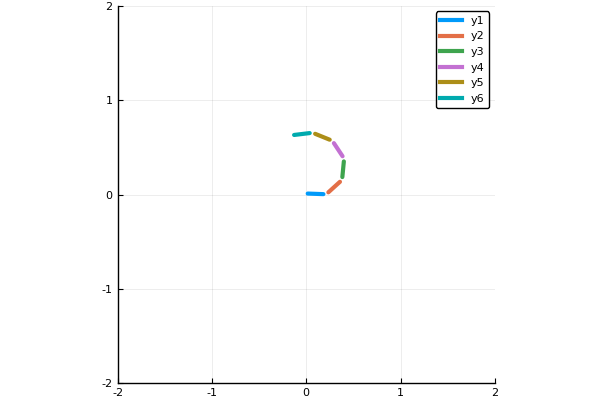

In [9]:
freq = 100 # intervals of plotting
camera_view = (45,45)
v = isdefined(:plot_dir) ? plot_dir : system.ndim==2 ? (1,2) : (1,2,3)

@manipulate for i in 1:Int(round(length(t_reg)/freq)-1)

    if system.ndim == 2
        k = i*freq+1
        # first body
        p = plot(vs_reg[k][1,:,v[1]],vs_reg[k][1,:,v[2]], linewidth=3, aspect_ratio=:equal)        
        # the rest bodys
        for j in 2:system.nbody
            plot!(vs_reg[k][j,:,v[1]],vs_reg[k][j,:,v[2]], linewidth=3, aspect_ratio=:equal)            
        end    
        plot!(xlims=(-2,2), ylims=(-2,2))
        
    else
        k = i*freq+1
        h = [1:bodys[1].nverts;1]
        # first body        
        plot(vs_reg[k][1,h,v[1]],vs_reg[k][1,h,v[2]],vs_reg[k][1,h,v[3]], linewidth=3, aspect_ratio=:equal ,camera = camera_view)
        # the rest bodys
        for j in 2:system.nbody
            plot!(vs_reg[k][j,h,v[1]],vs_reg[k][j,h,v[2]],vs_reg[k][j,h,v[3]], linewidth=3, aspect_ratio=:equal ,camera = camera_view)
        end    
        plot!(xlims=(-2,2), ylims=(-2,2), zlims=(-2,2))        
    end

end